In [87]:
# Importação das bibliotecas necessárias

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
pip install lightgbm

In [43]:
# Caminho do arquivo extraido
dataset_extraido = "../dados/dataset_phishing/PhiUSIIL_Phishing_URL_Dataset.csv"

# Carregamento dos dados usando o pandas
dataframe = pd.read_csv(dataset_extraido)

# Removendo as colunas insignificante para o algoritmo 'FILENAME', 'URL', 'DOMAIN' como já vimos no notebook da análise exploratória
dataframe = dataframe.drop(columns=['FILENAME', 'URL', 'Domain'])

# Exibe os 10 primeiros registros dos dados
dataframe.head(10)

,URLLength,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,com,100.0,1.000000,0.522907,0.061933,3,1,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,de,100.0,0.666667,0.032650,0.050207,2,1,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,uk,100.0,0.866667,0.028555,0.064129,2,2,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,com,100.0,1.000000,0.522907,0.057606,3,1,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,org,100.0,1.000000,0.079963,0.059441,3,1,...,1,0,1,244,15,34,72,1,85,1
5,30,23,0,org,100.0,1.000000,0.079963,0.060614,3,1,...,0,0,1,35,1,11,86,0,14,1
6,25,18,0,com,100.0,1.000000,0.522907,0.063549,3,1,...,0,0,1,32,4,14,44,2,17,1
7,25,18,0,com,100.0,1.000000,0.522907,0.060486,3,1,...,0,0,1,24,2,22,36,0,15,1
8,29,22,0,in,100.0,1.000000,0.005084,0.056980,2,1,...,0,0,1,71,4,9,40,1,317,1
9,18,11,0,org,100.0,1.000000,0.079963,0.070497,3,1,...,0,0,1,10,1,12,173,6,65,1


In [33]:
# Verificando balanceamento das classes alvo
print("Distribuição das classes:")
print(dataframe['label'].value_counts(normalize=True))

Distribuição das classes:
label
1    0.571895
0    0.428105
Name: proportion, dtype: float64


In [53]:
"""
Como a coluna TLD pode ser relevante e tem 695 valores únicos dos totais 235.795
agrupamos os valores menos frequentes em uma unica categoria e convertemos para numeros ordinais
"""
# Agrupando valores menos frequentes com minimo de 10 ocorrências para a coluna TLD
tld_contagem = dataframe['TLD'].value_counts()
limite = 10 
tld_raros = tld_contagem[tld_contagem < limite].index
dataframe['TLD'] = dataframe['TLD'].replace(tld_raros, 'Outros')

# Transformando dados da coluna TLD que era object em variaveis categóricas
codificador = OrdinalEncoder()
dataframe['TLD'] = codificador.fit_transform(dataframe[['TLD']])

In [69]:
"""
Como a coluna Title pode ser relevante e tem 197.874 valores únicos dos totais 235.795, indica que os dados são altamente cardinalizados
e que valores únicos são numerosos, então vamos usar o comprimento do titulo como feature e adicionar hashes com uma quantidade fixa de inteiros 
para reduzir a dimensionalidade, pois adicionamos numeros inteiros para as categorias com a mesma unicidade.
"""
# Adicionando comprimento do titulo como caracteristica
dataframe['Comprimento_Titulo'] = dataframe['Title'].str.len()

# Configurando o HashingVectorizer
hashing = HashingVectorizer(n_features=100)
titulo_hash = hashing.fit_transform(dataframe['Title'].fillna(""))

# Adiciona a coluna do titulo como hashes
titulo_hash_df = pd.DataFrame(titulo_hash.toarray(), columns=[f'titulo_hash_{i}' for i in range(100)])
dataframe = pd.concat([dataframe, titulo_hash_df], axis=1)

# Removemos a coluna original
dataframe.drop(columns='Title', inplace=True)

## Label; 0 phishing, 1 legítimo

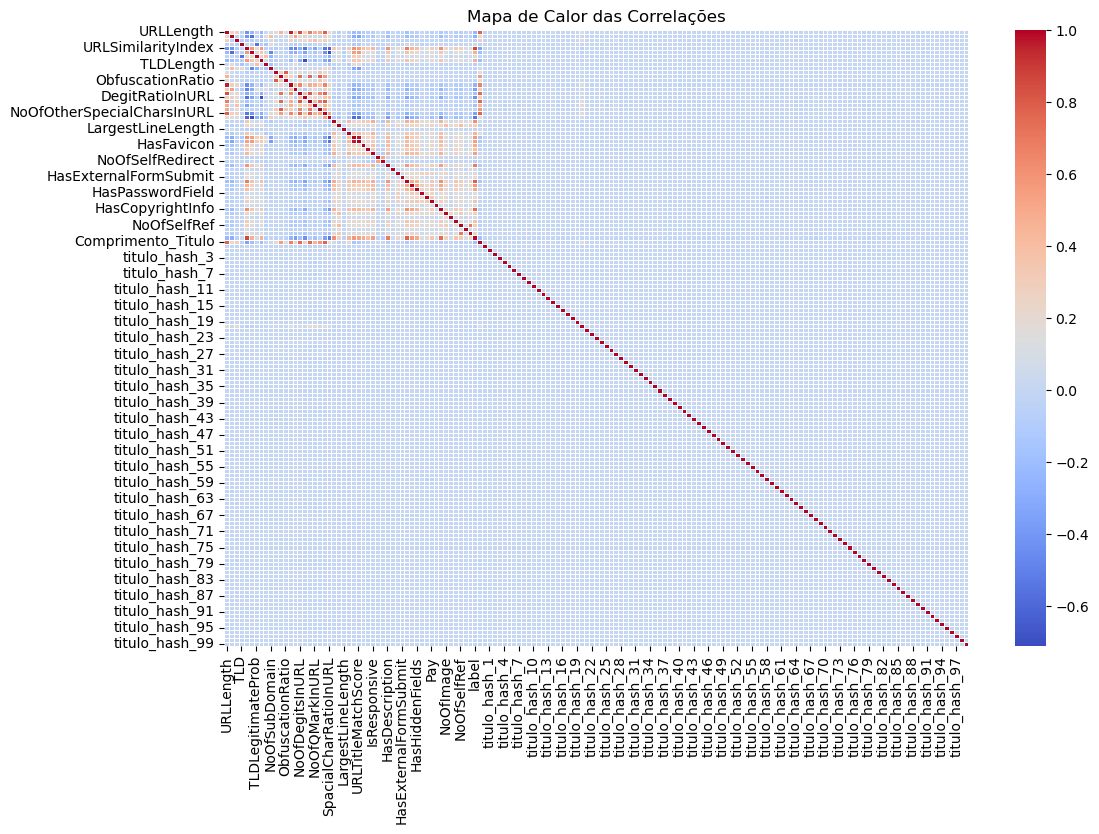

In [71]:
# Mapa de calor da correlação
plt.figure(figsize=(12,8))
sns.heatmap(dataframe.corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Mapa de Calor das Correlações")
plt.show()

In [79]:
# Separa os dados de entrada e saida
X = dataframe.drop(columns='label')
y = dataframe['label']

# Preserva o nome das colunas
colunas_originais = X.columns

# Eliminação das caracteristicas de baixas variâncias
selecao = VarianceThreshold(threshold=0.01)
X_reduzido = selecao.fit_transform(X)

# Verificar as colunas que restaram
colunas_selecionadas = colunas_originais[selecao.get_support()]

# Identificação das variaveis mais importantes
rf = RandomForestClassifier(random_state=42)
rf.fit(X_reduzido, y)
importantes = rf.feature_importances_

# Exibindo as 10 caracteristicas mais importantes
caracteristicas_importantes = pd.Series(importantes, index=colunas_selecionadas).sort_values(ascending=False)
print("10 caracteristicas mais importantes")
print(caracteristicas_importantes.head(10))

10 caracteristicas mais importantes
URLSimilarityIndex            0.198302
NoOfExternalRef               0.181691
LineOfCode                    0.105058
NoOfImage                     0.101683
NoOfSelfRef                   0.089905
NoOfJS                        0.073733
NoOfCSS                       0.047164
HasDescription                0.030604
LargestLineLength             0.027460
NoOfOtherSpecialCharsInURL    0.023877
dtype: float64


In [81]:
# Criamos um novo dataframe com os dados modificados após a engenharia
novo_dataset = "../dados/dataset_phishing/dados_projetados.csv"
dataframe.to_csv(novo_dataset, index=False)
print(f"Novo Dataset salvo em {novo_dataset}")

Novo Dataset salvo em ../dados/dataset_phishing/dados_projetados.csv


In [85]:
# Divisão do dataset, separação em treino e teste
y = dataframe['label']
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [93]:
# Criação de pipelina para Random Forest

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(max_depth=10, random_state=42))
])

lgbm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier(random_state=42))
])

In [95]:
# Treinamento e avaliação dos algoritmos
rf_pipeline.fit(X_treino, y_treino)
rf_predicoes = rf_pipeline.predict(X_teste)

lgbm_pipeline.fit(X_treino, y_treino)
lgbm_predicoes = rf_pipeline.predict(X_teste)

print("Avaliação Random Forest")
print(classification_report(y_teste, rf_predicoes))
print("Acurácia:", accuracy_score(y_teste, rf_predicoes))

print()

print("Avaliação LightGBM")
print(classification_report(y_teste, lgbm_predicoes))
print("Acurácia:", accuracy_score(y_teste, lgbm_predicoes))

[LightGBM] [Info] Number of positive: 94395, number of negative: 70661
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8898
[LightGBM] [Info] Number of data points in the train set: 165056, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571897 -> initscore=0.289594
[LightGBM] [Info] Start training from score 0.289594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Avaliação Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30284
           1       1.00      1.00      1.00     40455

    accuracy                           1.00     70739
   macro avg       1.00      1.00      1.00     70739
weighted avg       1.00      1.00      1.00     70739

Acurácia: 0.9999

In [97]:
from sklearn.model_selection import cross_val_score

# Validação cruzada para Random Forest
scores_rf = cross_val_score(rf_pipeline, X, dataframe['label'], cv=5)
print("Acurácia média com validação cruzada (Random Forest):", scores_rf.mean())

# Validação cruzada para LightGBM
scores_lgbm = cross_val_score(lgbm_pipeline, X, dataframe['label'], cv=5)
print("Acurácia média com validação cruzada (LightGBM):", scores_lgbm.mean())

Acurácia média com validação cruzada (Random Forest): 0.9999872770839076
[LightGBM] [Info] Number of positive: 107880, number of negative: 80756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9285
[LightGBM] [Info] Number of data points in the train set: 188636, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571895 -> initscore=0.289587
[LightGBM] [Info] Start training from score 0.289587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107880, number of negative: 80756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tr